# **Sentiment Analysis in Python: Hotel Reviews Data**

## Executive Summary

This project develops a sentiment analysis system to categorize hotel reviews using [Datafiniti’s Business Database](https://data.world/datafiniti/hotel-reviews). By processing textual review titles into numerical features, I built a multiclass logistic regression model to predict whether a stay is rated as poor (<3), neutral (=3), or excellent (>3).

Beyond simple prediction, this analysis investigates the "why" behind model performance. It specifically examines how class imbalance (where positive reviews significantly outnumber negative ones) affects accuracy. By visualizing feature importance and model errors, the project identifies the specific vocabulary that drives sentiment and outlines the mathematical challenges of training models on skewed data.

## Business Impact

This system allows a company to automate the monitoring of customer feedback at scale. By identifying the specific terms that lead to a "lower than 3" rating, management can pinpoint exact service failures, such as cleanliness or staff responsiveness, and allocate resources to fix those issues immediately to prevent brand damage.

In [3]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#Load dataset
df = pd.read_csv('Datafiniti_Hotel_Reviews.csv')

#Preprocess data: clean the text
def preprocess_text(text):
    #Handle any non-string values
    if not isinstance(text, str):
        return ""  #Return an empty string if the value is not a string

    text = text.lower() #Lowercase
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) #Remove punctuation
    text = re.sub(r"\s+", " ", text).strip() #Remove extra spaces
    return text

df['reviews.title'] = df['reviews.title'].apply(preprocess_text)

#Convert ratings to categorical labels
def categorize_rating(rating):
    if rating < 3:
        return 'less_than_3'
    elif rating == 3:
        return 'equal_to_3'
    else:
        return 'greater_than_3'

df['rating_category'] = df['reviews.rating'].apply(categorize_rating)

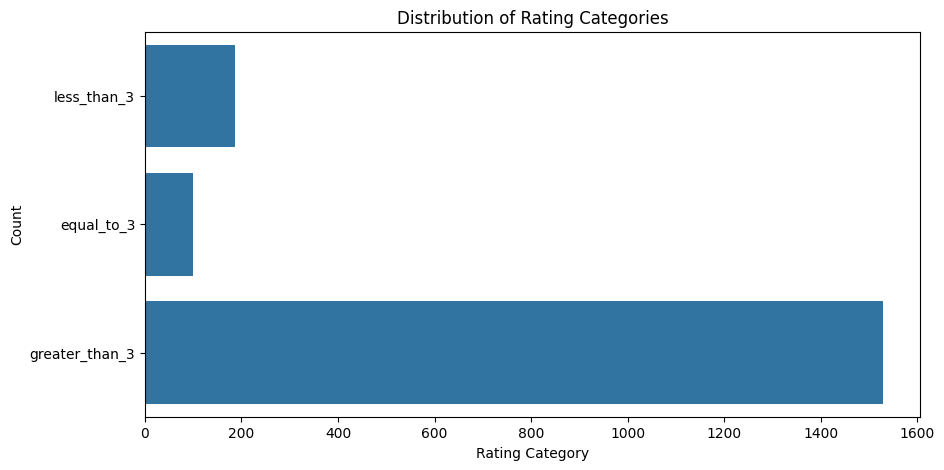

In [4]:
#Visualize distribution of original/actual ratings
plt.figure(figsize=(10, 5))
sns.countplot(df['rating_category'], order=['less_than_3', 'equal_to_3', 'greater_than_3'])
plt.title('Distribution of Rating Categories')
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.show()

In [5]:
#Vectorize text data using TF-IDF vectorization: convert the text data into numerical form
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['reviews.title'])

## Why TfidfVectorizer?

I chose TfidfVectorizer (Term Frequency-Inverse Document Frequency) over CountVectorizer to better capture the importance of specific words within the context of the entire dataset.

The Problem with CountVectorizer is that it simply counts how many times a word appears. In hotel reviews, common words like "room" or "hotel" show up everywhere but express neither positive nor negative sentiment.

The TF-IDF Advantage is that it applies a weight that increases with the number of times a word appears in a specific review but is offset by the frequency of the word in the overall corpus. This allows the model to ignore generic language and focus on descriptive, high-value terms like "filthy" or "exquisite" that actually drive the rating prediction.

## Model Training and Evaluation

To evaluate the predictive power of the features, I partitioned the dataset into training and testing sets. I implemented a Multiclass Logistic Regression model to establish a performance baseline, allowing for a direct assessment of how well textual patterns correlate with the three rating categories.

## Model Performance Visualization

After training the model, I generated a series of visualizations to evaluate its effectiveness and identify specific areas of misclassification. By using a Confusion Matrix and Precision-Recall metrics, I can visualize exactly where the model confuses neutral sentiment with positive or negative ratings.

In [6]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, df['rating_category'], test_size=0.2, random_state=42)

#Train model
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

#Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

    equal_to_3       0.50      0.05      0.10        19
greater_than_3       0.85      0.99      0.92       304
   less_than_3       0.43      0.07      0.12        41

      accuracy                           0.84       364
     macro avg       0.59      0.37      0.38       364
  weighted avg       0.78      0.84      0.78       364



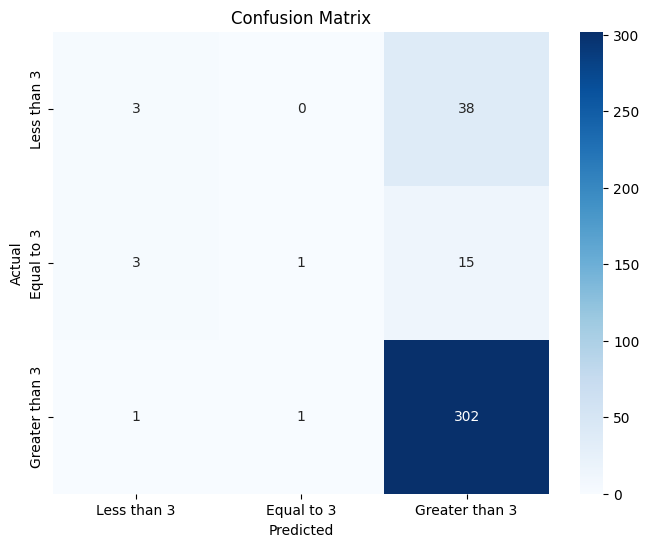

In [7]:
#Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=['less_than_3', 'equal_to_3', 'greater_than_3'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Less than 3', 'Equal to 3', 'Greater than 3'], yticklabels=['Less than 3', 'Equal to 3', 'Greater than 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

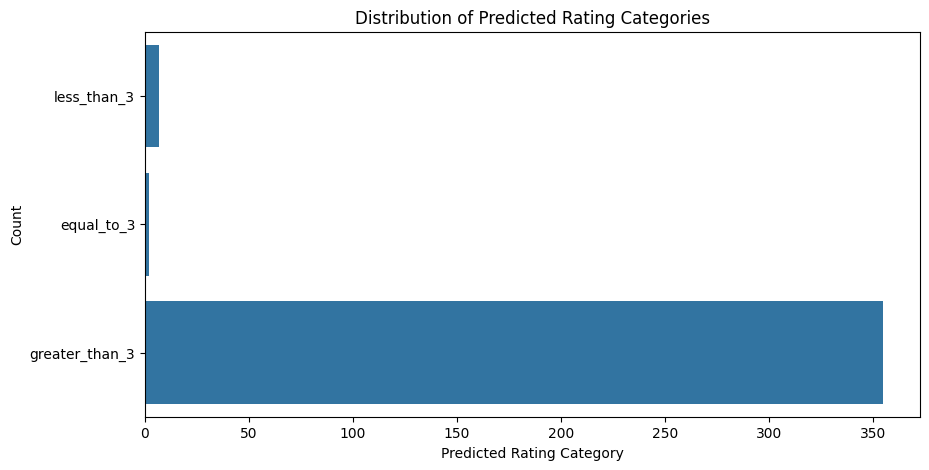

In [8]:
#Visualize distribution of predicted ratings
predicted_categories = pd.Series(y_pred, name='Predicted Rating Category')
plt.figure(figsize=(10, 5))
sns.countplot(predicted_categories, order=['less_than_3', 'equal_to_3', 'greater_than_3'])
plt.title('Distribution of Predicted Rating Categories')
plt.xlabel('Predicted Rating Category')
plt.ylabel('Count')
plt.show()

## Feature Importance Analysis

To understand the logic behind the model’s predictions, I extracted the coefficients from the logistic regression. This allows for a direct look at which specific words are the strongest predictors for each category. Visualizing these coefficients highlights the vocabulary that the model associates with high versus low ratings.

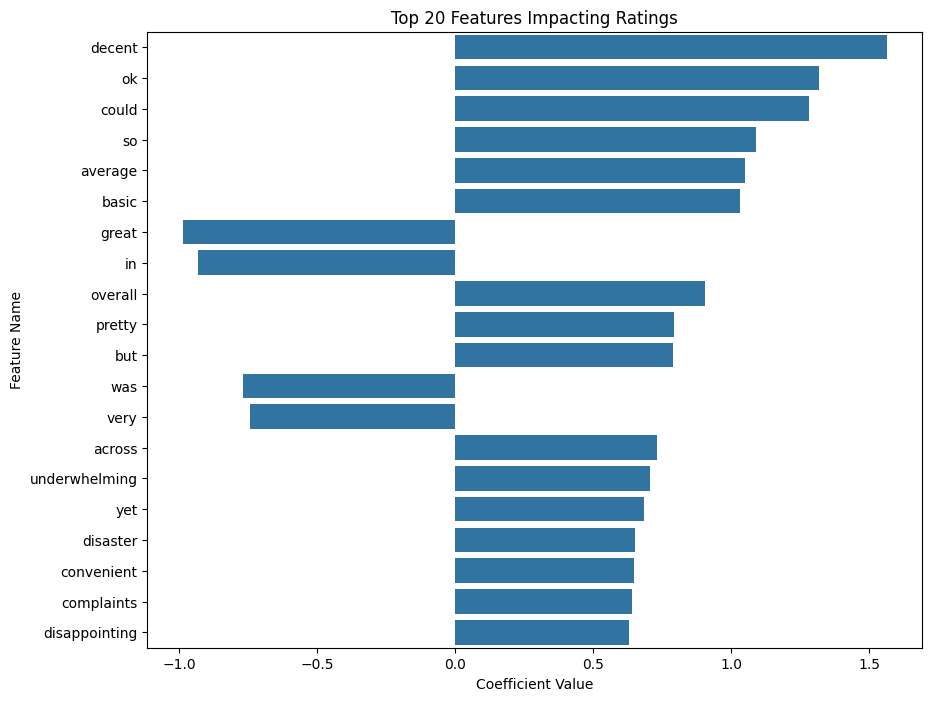

In [9]:
#Feature importance visualization (top 20 features)
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_.flatten()
top_features = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)[:20]
top_feature_names = [x[1] for x in top_features]
top_feature_values = [x[0] for x in top_features]

plt.figure(figsize=(10, 8))
sns.barplot(x=top_feature_values, y=top_feature_names)
plt.title('Top 20 Features Impacting Ratings')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.show()

In [10]:
#Example prediction
new_review_title = "Worst hotel in town"
processed_title = preprocess_text(new_review_title)
title_vector = vectorizer.transform([processed_title])
predicted_category = model.predict(title_vector)

print(f"Review Title: {new_review_title}")
print(f"Predicted Rating Category: {predicted_category[0]}")

Review Title: Worst hotel in town
Predicted Rating Category: greater_than_3


The model gives an unreasonable prediction of the class of this review; the sentiment of the review is negative, and the model predicts that the review will have an associated rating that is greater than 3 (positive sentiment).

In [11]:
#Example prediction
new_review_title = "Hotel is just okay"
processed_title = preprocess_text(new_review_title)
title_vector = vectorizer.transform([processed_title])
predicted_category = model.predict(title_vector)

print(f"Review Title: {new_review_title}")
print(f"Predicted Rating Category: {predicted_category[0]}")

#Example prediction
new_review_title = "Best hotel in town"
processed_title = preprocess_text(new_review_title)
title_vector = vectorizer.transform([processed_title])
predicted_category = model.predict(title_vector)

print(f"Review Title: {new_review_title}")
print(f"Predicted Rating Category: {predicted_category[0]}")

Review Title: Hotel is just okay
Predicted Rating Category: greater_than_3
Review Title: Best hotel in town
Predicted Rating Category: greater_than_3


## Results and Performance Analysis

The model demonstrates a significant bias toward the majority class. While the overall accuracy is ~0.84 (306 correct predictions out of 364), this metric is misleading due to the heavy imbalance in the dataset. Because positive reviews (greater than 3) outnumber neutral and negative reviews, the model achieves a high accuracy by defaulting to the majority category.

## Performance Disparity

The F1-scores for the "less than three" and "equal to three" categories are low, signaling that the model struggles to identify negative and neutral sentiment.

*   Positive Reviews: 302 out of 304 reviews were correctly predicted.
*   Neutral Reviews: Only 1 out of 19 reviews was correctly predicted.
*   Negative Reviews: Only 3 out of 41 reviews were correctly predicted.

## Metric Reliability

The disparity in precision across categories confirms that accuracy is an insufficient metric for this dataset. In this context, the F1-score provides a more reliable measure of model performance as it accounts for both false positives and false negatives across the imbalanced classes.

## Proposed Improvements

The primary bottleneck for performance is the skewed distribution of the training data. To improve the classification of minority classes, the next phase of this project will employ Synthetic Minority Oversampling Technique (SMOTE) to balance the dataset and force the model to learn the distinct features of neutral and negative feedback.